In [1]:

from matplotlib import pyplot as plt
import numpy as np
from RL.TCell import TCell_Threshold
import pandas as pd
from RL.APC import StochasticAPC


\frac{# } Re{producing the results of Baumgart et al}.
We opted not to use the metaphorical terminology of the search theory of Baumgart et al. and rather stick to the target terminology:
Instead of a `Haystack`, we search a `Body`, which instead of containing multiple `Haybales` contains multiple `APCs`, which are either `positive`, making the body `infected` or `negative`, making the body `healthy`.

M := number of positive APCs

N := total number of APCs

$p = M/N :=$ probability of 1 APC to be positive, expressed as an average over all APCs

n := number of checked APCs

k := number of APCs truly identified as positive

$p   =  \frac{M }{N}$

### Global evaluation
When performing a test on multiple APCs, with these metrics you evaluate a T-Cells performance across the whole population to determine how well it can identify a `infected` body.

$TPR =  \frac{TP}{(TP + FN)}$

$FPR =  \frac{FP}{(TN + FP)}$

$TNR =  \frac{TN}{(TN + FP)}$

$FNR =  \frac{FN}{(FN + TP)}$

### Local evaluation
When performing a test on a single APC, with these metrics you evaluate a T-Cells performance on a single case to determine how well it can identify a `positive` APC. While this is not measurable (a population of 1 has either k = 1 for a tp or 0 else), it is controllable via the agent (TCell) policy.

$tpr =  \frac{tp}{(tp + fn)}$

$fpr =  \frac{fp}{(tn + fp)}$

$tnr =  \frac{tn}{(tn + fp)}$

$fnr =  \frac{fn}{(fn + tp)}$






# Setup
## Environment: APC
Each APC is a reinforcement learning environment. It carries the attribute `isPositive`, which is either `True` or `False`. This is invisible to the agent.
### States: S
Each state is an array of three values:
1. the timestep `t`, natural numbers
2. the perceived probability of the APC being positive `q` $\in [0, 1]$. This starts at `0.5` and gets nudged in either direction toward 0 or 1, depending on the attribute `isPositive`.
3. `1` if this state is a terminal state, `0` at the start of an episode and made positive by the agent

### Actions: A
- `stay`: advance to the next timestep without making a decision
- `positive`: classify the APC to be `positive`
- `negative`: classify the APC to be `negative`

### Rewards: R
The values of the large rewards and penalties are subject to experimentation, as they strongly influence the agent's behaviour.
- `stay`: `-1`, penalty for waiting, encourages making a decision
- `positive`:
    - `tp`: some large reward (e.g. `100`)
    - `fp`: some large penalty (e.g. `-100`)
- `negative`: classify the APC to be `negative`
    - `tn`: some large reward (e.g. `100`)
    - `fn`: some large penalty (e.g. `-100`)

## T-Cell: Agent
The agent for the environments is a TCell.
It has a policy $\pi: S X A \rightarrow \mathbb{R} \in [0,1]$

Since the state-space is continuous, its policy is not tabular but rather a function, which can take many forms. For this purpose we design a `Policy` class, which is flexible and can, for example, be a linear function or a Neural Network.


In [ ]:
# play a single episode with a TCell

Baumgart et al. display a plot that shows the development of the global TPR as the number of checked APCs increases, for different probabilities of harmfulness. Here we recreate this plot using our environments


result   t     FN     FP     TN     TP       TPR
0        1  12475  12446  12532  12547  0.501439
1        2   2676   2822   5637   5865  0.686688
2        3    963    975   2958   3104  0.763216
3        4    506    510   1981   2003  0.798326
4        5    322    348   1687   1643  0.836132
5        6    142    144    919    795  0.848453
6        7    125    122    885    868  0.874119
7        8     70     58    431    441  0.863014
8        9     67     52    440    441  0.868110
9       10     39     44    475    442  0.918919
10      11     32     45    478    445  0.932914
11      12     37     47    462    454  0.924644
12      14     35     47    474    444  0.926931
13      16     32     21    481    466  0.935743
14      20     20     26    489    465  0.958763
15      25     13     18    478    491  0.974206
16      33     14     16    492    478  0.971545
17      50      8     10    499    483  0.983707
18      99      8      7    476    509  0.984526


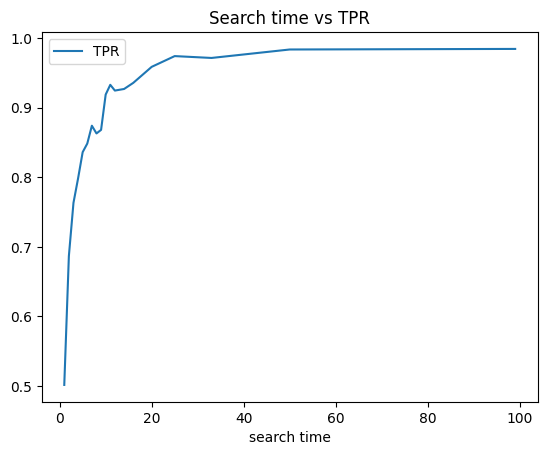

In [3]:


def test_TCell_Threshold(N=1000):
    # test many different TCell_Treshold instances with
    # varying thresholds
    # plot their results: FPR vs treshold
    env = StochasticAPC()
    results = []

    for i in np.arange(0, 100, 1):
        # make 100 episodes per each of the 100 different treshold levels
        agent = TCell_Threshold(env, T=100, threshold=i/100)
        for j in range(N):
            R, t, transitions = agent.episode(epsilon=0.1, verbose=False)
            final_action = transitions[-1][1]
            final_reward = transitions[-1][2]
            result = env.eval_action_reward(final_action, final_reward)
            results.append({"result":result, "t":t})

    df = pd.DataFrame(results)
    df = df.groupby("t")["result"].value_counts().unstack(fill_value=0).reset_index()
    df["TPR"] = df["TP"] / (df["TP"] + df["FN"])
    print(df)
    df.plot.line("t", "TPR", xlabel="search time", title="Search time vs TPR")
    plt.show()

test_TCell_Threshold()